In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu 

from mri_data import file_manager as fm

In [3]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = msmri_home / "monai_analysis" / "choroid_pineal_pituitary_T1-1"

## Data Cleaning

Load volume dataset

In [4]:
df_vols = pd.read_csv(curr_dir / "clinical_data_full.csv")
df_vols = df_vols.set_index("subid")
keep_cols = [
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "tiv",
    "flair_contrast",
    "label",
    "scan_folder",
    "age",
]

not_nas = (
    ~df_vols["pineal_volume"].isna()
    & ~df_vols["choroid_volume"].isna()
    & ~df_vols["pituitary_volume"].isna()
)
df_vols = df_vols.loc[not_nas, keep_cols]

In [5]:
def subject_to_subid(subject):
    if not isinstance(subject, str):
        return None
    re_match = re.match(r"ms(\d{4})", subject)
    if re_match:
        return_val = int(re_match[1])
        return return_val
    else:
        return None

In [6]:
df_full = pd.read_csv(msmri_datadir / "Clinical_Data_All_updated.csv")
df_full.insert(0, "subid", df_full["ID"].map(subject_to_subid))
df_full = df_full.set_index("subid")

df = pd.merge(
    df_vols,
    df_full.loc[:, ~df_full.columns.isin(df_vols.columns)],
    how="outer",
    on="subid",
)

df.loc[:, "extracted_EDSS"] = [
    float(val) if val != "." else None for val in df["extracted_EDSS"]
]  #! figure out what to do with "."
df.loc[:, ["EDSS"]] = pd.Categorical(df["extracted_EDSS"], ordered=True)
df.loc[df["PRL"] == "#VALUE!", "PRL"] = None
df.loc[:, "PRL"] = [
    int(val) if val != "#VALUE!" and val is not None else None for val in df["PRL"]
]
df.loc[df["dzdur"] == "#VALUE!", "dzdur"] = None

In [7]:
prl_levels = [range(0, 1), range(1, 3), range(3, 5), range(5, df["PRL"].max() + 1)]
df.loc[:, ["PRL_LEVEL"]] = None
for i, level in enumerate(prl_levels):
    df.loc[df["PRL"].isin(level), ["PRL_LEVEL"]] = i
df.loc[:, ["PRL_LEVEL"]] = pd.Categorical(df["PRL_LEVEL"], ordered=True)

In [8]:
def check_nind(subtype):
    if type(subtype) is not str:
        return False
    if "migraine" in subtype:
        return True
    elif "IIH" in subtype:
        return True
    elif "Migraine" in subtype:
        return True
    else:
        return False

In [9]:
def check_nind2(subtype):
    if type(subtype) is not str:
        return False
    keywords = ["migraine", "IIH", "anxiety", "Migraine"]
    for word in keywords:
        if word in subtype:
            return True
    return False

Add columns for volumes normalized by TIV

In [10]:
df.loc[:, ["norm_choroid_volume"]] = df["choroid_volume"] / df["tiv"]
df.loc[:, ["norm_pineal_volume"]] = df["pineal_volume"] / df["tiv"]
df.loc[:, ["norm_pituitary_volume"]] = df["pituitary_volume"] / df["tiv"]

### Categorize Disease Types

- RMS vs MS vs !MS
- MS vs !MS
- MS vs OIND vs NIND

`dz_type` has relapsing MS (RMS) versus progressive MS (PMS) verusus not MS (!MS)

In [11]:
try:
    df.insert(18, "dz_type", df["ms_type"])
except Exception:
    pass

df.loc[:, "dz_type"] = df["ms_type"]

df.loc[df["ms_type"].isin(["CIS", "RRMS"]), "dz_type"] = "RMS"
df.loc[df["ms_type"].isin(["PPMS", "SPMS", "RPMS", "PRMS"]), "dz_type"] = "PMS"
df.loc[df["ms_type"].isin(["NIND", "OIND", "HC"]), "dz_type"] = "!MS"
# df.loc[(df['dz_type'] == "NIND") & (df['subtype'].map(check_nind2)), "dz_type"] = "HC"
print(df["dz_type"].unique())
print(sum(df["dz_type"] == "HC"))

['RMS' 'PMS' '!MS' 'UNK' 'RIS']
0


`dz_type2` has MS versus !MS and UNK

In [12]:
try:
    df.insert(18, "dz_type2", df["dz_type"])
except Exception:
    pass

df.loc[:, "dz_type2"] = df["dz_type"]

df.loc[df["dz_type"].isin(["RMS", "PMS"]), "dz_type2"] = "MS"
df["dz_type2"].unique()

array(['MS', '!MS', 'UNK', 'RIS'], dtype=object)

`dz_type3` has MS v OIND v NIND

In [13]:
try:
    df.insert(18, "dz_type3", df["ms_type"])
except Exception:
    pass

df.loc[:, "dz_type3"] = df["ms_type"]

df.loc[
    df["ms_type"].isin(["PPMS", "SPMS", "RPMS", "PRMS", "RRMS", "CIS"]), "dz_type3"
] = "MS"
df["dz_type3"].unique()

array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

`dz_type4`

In [14]:
try:
    df.insert(18, "dz_type4", df["dz_type3"])
except Exception:
    pass

df.loc[:, "dz_type4"] = df["dz_type3"]

df.loc[
    (df["dz_type4"] == "NIND") & (df.loc[:, "subtype"].map(check_nind2)), "dz_type4"
] = "HC"

`dz_type5`

In [15]:
try:
    df.insert(18, "dz_type5", df["ms_type"])
except Exception:
    pass

df.loc[:, "dz_type5"] = df["ms_type"]

df.loc[df["ms_type"].isin(["CIS", "RRMS"]), "dz_type5"] = "RMS"
df.loc[df["ms_type"].isin(["PPMS", "SPMS", "RPMS", "PRMS"]), "dz_type5"] = "PMS"
# df.loc[(df['dz_type5'] == "NIND") & (df['subtype'].map(check_nind2)), "dz_type5"] = "HC"
print(df["dz_type5"].unique())

['RMS' 'PMS' 'NIND' 'UNK' 'HC' 'OIND' 'RIS']


## Descriptive Stats

In [16]:
print(len(df), "patients in total")
nRMS = sum(df["dz_type"] == "RMS")
nPMS = sum(df["dz_type"] == "PMS")
nNotMS = sum(df["dz_type"] == "!MS")
print(nRMS, "patients with RMS", f"({round(nRMS / len(df), 2)})")
print(nPMS, "patients with PMS", f"({round(nPMS / len(df), 2)})")
print(nNotMS, "patients w/o MS", f"({round(nNotMS / len(df), 2)})")

564 patients in total
368 patients with RMS (0.65)
97 patients with PMS (0.17)
92 patients w/o MS (0.16)


In [17]:
print(len(df), "patients in total")
nMS = sum(df["dz_type3"] == "MS")
nOIND = sum(df["dz_type3"] == "OIND")
nNIND = sum(df["dz_type3"] == "NIND")
print(nMS, "patients with MS", f"({round(nMS / len(df), 2)})")
print(nOIND, "patients with OIND", f"({round(nOIND / len(df), 2)})")
print(nNIND, "patients w/o NIND", f"({round(nNIND / len(df), 2)})")

564 patients in total
465 patients with MS (0.82)
41 patients with OIND (0.07)
49 patients w/o NIND (0.09)


In [18]:
print("Female subjects:     {:0.2f}".format(sum(df["sex"] == "Female") / len(df)))
print("Average age at scan: {:0.2f}".format(df["age"].mean()))

Female subjects:     0.79
Average age at scan: 47.77


In [19]:
df_rrms = df.loc[df["dz_type"] == "RMS"]
print("RMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_rrms["sex"] == "Female") / len(df_rrms)))
print("\tAge:     {:0.2f}".format(df_rrms["age"].mean()))

df_pms = df.loc[df["dz_type"] == "PMS"]
print("PMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_pms["sex"] == "Female") / len(df_pms)))
print("\tAge:     {:0.2f}".format(df_pms["age"].mean()))

df_notms = df.loc[df["dz_type"] == "!MS"]
print("!MS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_notms["sex"] == "Female") / len(df_notms)))
print("\tAge:     {:0.2f}".format(df_notms["age"].mean()))

RMS Patients:
	Female:  0.84
	Age:     44.64
PMS Patients:
	Female:  0.59
	Age:     58.24
!MS Patients:
	Female:  0.82
	Age:     49.70


#### Volumes

In [20]:
# choroid
print("Choroid volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms["choroid_volume"].mean()))
print("\tPMS:    {:0.2f}".format(df_pms["choroid_volume"].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms["choroid_volume"].mean()))

# pineal
print("Pineal volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms["pineal_volume"].mean()))
print("\tPMS:    {:0.2f}".format(df_pms["pineal_volume"].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms["pineal_volume"].mean()))

# pituitary
print("Pituitary volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms["pituitary_volume"].mean()))
print("\tPMS:    {:0.2f}".format(df_pms["pituitary_volume"].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms["pituitary_volume"].mean()))

Choroid volumes:
	RRMS:   1921.89
	PMS:    2464.00
	not-MS: 1973.78
Pineal volumes:
	RRMS:   241.80
	PMS:    228.35
	not-MS: 267.28
Pituitary volumes:
	RRMS:   694.03
	PMS:    651.02
	not-MS: 690.05


In [21]:
print("Choroid volumes:")
choroid_ms_mean = df[df["dz_type2"] == "MS"].choroid_volume.mean()
choroid_notms_mean = df[df["dz_type2"] == "!MS"].choroid_volume.mean()
print("\tMS:     {:0.2f}".format(choroid_ms_mean))
print("\tnot-MS: {:0.2f}".format(choroid_notms_mean))

print("\nPineal volumes")
pineal_ms_mean = df[df["dz_type2"] == "MS"].pineal_volume.mean()
pineal_notms_mean = df[df["dz_type2"] == "!MS"].pineal_volume.mean()
print("\tMS:     {:0.2f}".format(pineal_ms_mean))
print("\tnot-MS: {:0.2f}".format(pineal_notms_mean))

print("\nPituitary volumes")
pituitary_ms_mean = df[df["dz_type2"] == "MS"].pituitary_volume.mean()
pituitary_notms_mean = df[df["dz_type2"] == "!MS"].pituitary_volume.mean()
print("\tMS:     {:0.2f}".format(pituitary_ms_mean))
print("\tnot-MS: {:0.2f}".format(pituitary_notms_mean))

Choroid volumes:
	MS:     2033.73
	not-MS: 1973.78

Pineal volumes
	MS:     239.02
	not-MS: 267.28

Pituitary volumes
	MS:     685.16
	not-MS: 690.05


In [22]:
print("Choroid volumes:")
choroid_ms_mean = df[df["dz_type3"] == "MS"].choroid_volume.mean()
choroid_oind_mean = df[df["dz_type3"] == "OIND"].choroid_volume.mean()
choroid_nind_mean = df[df["dz_type3"] == "NIND"].choroid_volume.mean()
print("\tMS:   {:0.2f}".format(choroid_ms_mean))
print("\tOIND: {:0.2f}".format(choroid_oind_mean))
print("\tNIND: {:0.2f}".format(choroid_nind_mean))


print("\nPineal volumes")
pineal_ms_mean = df[df["dz_type2"] == "MS"].pineal_volume.mean()
pineal_oind_mean = df[df["dz_type3"] == "OIND"].pineal_volume.mean()
pineal_nind_mean = df[df["dz_type3"] == "NIND"].pineal_volume.mean()
print("\tMS:   {:0.2f}".format(pineal_ms_mean))
print("\tOIND: {:0.2f}".format(pineal_oind_mean))
print("\tNIND: {:0.2f}".format(pineal_nind_mean))


print("\nPituitary volumes")
pituitary_ms_mean = df[df["dz_type2"] == "MS"].pituitary_volume.mean()
pituitary_oind_mean = df[df["dz_type3"] == "OIND"].pituitary_volume.mean()
pituitary_nind_mean = df[df["dz_type3"] == "NIND"].pituitary_volume.mean()
print("\tMS:   {:0.2f}".format(pituitary_ms_mean))
print("\tOIND: {:0.2f}".format(pituitary_oind_mean))
print("\tNIND: {:0.2f}".format(pituitary_nind_mean))

Choroid volumes:
	MS:   2033.73
	OIND: 2014.44
	NIND: 1980.16

Pineal volumes
	MS:   239.02
	OIND: 243.42
	NIND: 287.07

Pituitary volumes
	MS:   685.16
	OIND: 704.53
	NIND: 678.36


## Plots

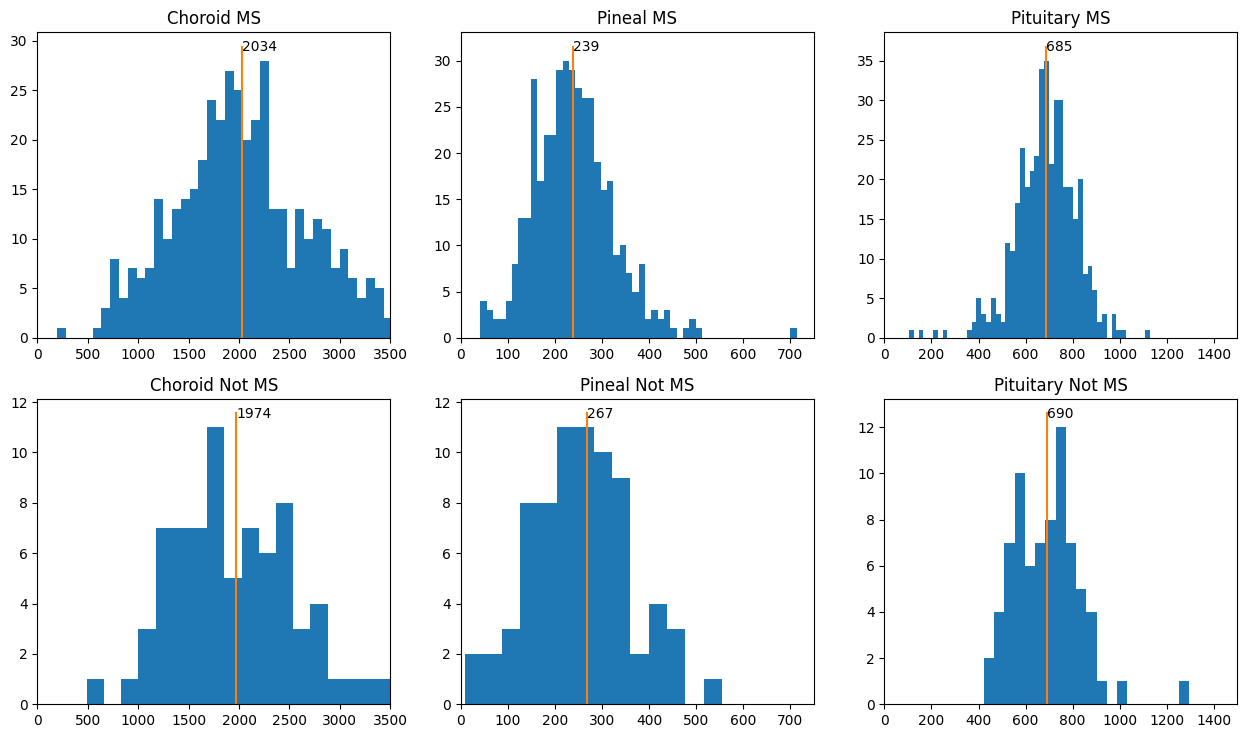

In [23]:
fig, ax = plt.subplots(2, 3)
ax[0, 0].hist(df.loc[df["dz_type2"] == "MS", "choroid_volume"], bins=50)
ax[0, 0].set_xlim([0, 3500])
ax[0, 0].set_title("Choroid MS")
ax[0, 0].plot([choroid_ms_mean, choroid_ms_mean], ax[0, 0].get_ylim())
text_y = ax[0, 0].get_ylim()[1] - ax[0, 0].get_ylim()[1] / 16
ax[0, 0].text(choroid_ms_mean, text_y, "{:0.0f}".format(choroid_ms_mean))

ax[1, 0].hist(df.loc[df["dz_type2"] == "!MS", "choroid_volume"], bins=20)
ax[1, 0].set_xlim([0, 3500])
ax[1, 0].set_title("Choroid Not MS")
ax[1, 0].plot([choroid_notms_mean, choroid_notms_mean], ax[1, 0].get_ylim())
text_y = ax[1, 0].get_ylim()[1] - ax[1, 0].get_ylim()[1] / 16
ax[1, 0].text(choroid_notms_mean, text_y, "{:0.0f}".format(choroid_notms_mean))


ax[0, 1].hist(df.loc[df["dz_type2"] == "MS", "pineal_volume"], bins=50)
ax[0, 1].set_xlim([0, 750])
ax[0, 1].set_title("Pineal MS")
ax[0, 1].plot([pineal_ms_mean, pineal_ms_mean], ax[0, 1].get_ylim())
text_y = ax[0, 1].get_ylim()[1] - ax[0, 1].get_ylim()[1] / 16
ax[0, 1].text(pineal_ms_mean, text_y, "{:0.0f}".format(pineal_ms_mean))

ax[1, 1].hist(df.loc[df["dz_type2"] == "!MS", "pineal_volume"], bins=30)
ax[1, 1].set_xlim([0, 750])
ax[1, 1].set_title("Pineal Not MS")
ax[1, 1].plot([pineal_notms_mean, pineal_notms_mean], ax[1, 1].get_ylim())
text_y = ax[1, 1].get_ylim()[1] - ax[1, 1].get_ylim()[1] / 16
ax[1, 1].text(pineal_notms_mean, text_y, "{:0.0f}".format(pineal_notms_mean))


ax[0, 2].hist(df.loc[df["dz_type2"] == "MS", "pituitary_volume"], bins=50)
ax[0, 2].set_xlim([0, 1500])
ax[0, 2].set_title("Pituitary MS")
ax[0, 2].plot([pituitary_ms_mean, pituitary_ms_mean], ax[0, 2].get_ylim())
text_y = ax[0, 2].get_ylim()[1] - ax[0, 2].get_ylim()[1] / 16
ax[0, 2].text(pituitary_ms_mean, text_y, "{:0.0f}".format(pituitary_ms_mean))

ax[1, 2].hist(df.loc[df["dz_type2"] == "!MS", "pituitary_volume"], bins=20)
ax[1, 2].set_xlim([0, 1500])
ax[1, 2].set_title("Pituitary Not MS")
ax[1, 2].plot([pituitary_notms_mean, pituitary_notms_mean], ax[1, 2].get_ylim())
text_y = ax[1, 2].get_ylim()[1] - ax[1, 2].get_ylim()[1] / 16
ax[1, 2].text(pituitary_notms_mean, text_y, "{:0.0f}".format(pituitary_notms_mean))

plt.subplots_adjust(bottom=0.1, right=2, top=1.5)

## Regression Models

Covariates: age, sex, TIV, contrast

### Linear Regression on Volume

Predict volume of structure with the following predictors:

- MS vs Not-MS
- MS vs OIND vs NIND
- RMS vs PMS

#### Choroid Plexus

##### MS vs not-MS

In [24]:
volume = "choroid_volume"

data = df[["dz_type2", "age", "sex", "tiv", "flair_contrast", "dzdur", volume]]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type2"].isin(["MS", "!MS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type2"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Male", "tiv", "MS", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     35.67
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           4.59e-26
Time:                        15:15:30   Log-Likelihood:                -3729.6
No. Observations:                 479   AIC:                             7469.
Df Residuals:                     474   BIC:                             7490.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           20.0308      2.173      9.219      0.0

##### MS vs NIND vs OIND

In [25]:
volume = "choroid_volume"

data = df[["dz_type3", "age", "sex", "tiv", "flair_contrast", "dzdur", volume]]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type3"].isin(["MS", "NIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type3"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "MS", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     33.88
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           1.14e-24
Time:                        15:15:30   Log-Likelihood:                -3483.6
No. Observations:                 447   AIC:                             6977.
Df Residuals:                     442   BIC:                             6998.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           20.3502      2.260      9.006      0.0

##### PMS v RMS

In [26]:
volume = "choroid_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "PMS", "intercept"]
# predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     33.00
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           8.59e-24
Time:                        15:15:30   Log-Likelihood:                -3152.5
No. Observations:                 405   AIC:                             6315.
Df Residuals:                     400   BIC:                             6335.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           16.5254      2.553      6.473      0.0

MS patients account add lesion volume to predictors. Greater lesion volume is associated with greater choroid volume. PMS is still associated with greater choroid volume compared to RMS

In [27]:
predictors = ["age", "Female", "tiv", "PMS", "lesion_vol_cubic", "PRL", "intercept"]
# predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     32.18
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           1.54e-31
Time:                        15:15:30   Log-Likelihood:                -3115.3
No. Observations:                 403   AIC:                             6245.
Df Residuals:                     396   BIC:                             6273.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 16.3252      2.597  

Text(0, 0.5, 'Lesion volume')

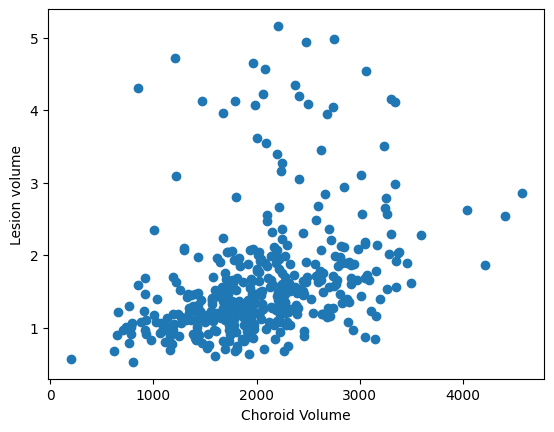

In [28]:
plt.scatter(data['volume'], data['lesion_vol_cubic'])
plt.xlabel("Choroid Volume")
plt.ylabel("Lesion volume")

##### PMS vs RMS vs OIND vs NIND

In [29]:
volume = "choroid_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS", "NIND", "OIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "RMS", "PMS", "OIND", "intercept"]
# predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     25.12
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           7.01e-26
Time:                        15:15:30   Log-Likelihood:                -3709.7
No. Observations:                 477   AIC:                             7433.
Df Residuals:                     470   BIC:                             7463.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           17.1708      2.348      7.314      0.0

Marginal Means

In [50]:
volume = "choroid_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS", "NIND", "OIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data["sex_male"] = data.sex.map({"Female": 0, "Male": 1})

model = ols(
    "volume ~ dz_type5 + sex_male + age + tiv", data=data
).fit()

ancova_table = sm.stats.anova_lm(model, typ=2)


In [51]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     20.01
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           8.13e-31
Time:                        15:37:53   Log-Likelihood:                -3676.0
No. Observations:                 475   AIC:                             7374.
Df Residuals:                     464   BIC:                             7420.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -187.0437    391.498  

/tmp/ipykernel_22416/2989188229.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x='dz_type5', y=marginal_means, data=data,


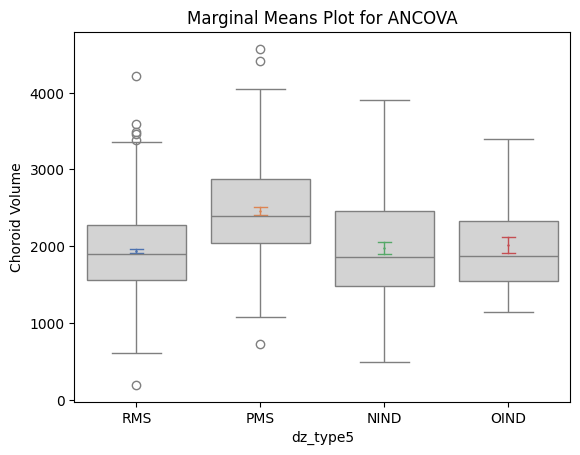

In [49]:
# Extract marginal means (using 'Group')
marginal_means = model.predict(data[['sex_male', 'age', 'tiv', 'dz_type5']].drop_duplicates())

# Plotting
# sns.boxplot(x='dz_type5', y=marginal_means, data=data, color='lightgray')  # Boxplot for context
sns.boxplot(x='dz_type5', y="volume", data=data, color='lightgray')  # Boxplot for context
# sns.stripplot(
#     data=data, x="dz_type5", y="volume",
#     dodge=True, alpha=.2, legend=False,
# )
sns.pointplot(x='dz_type5', y=marginal_means, data=data, 
              palette='deep', markers='o', linestyles='-', color='red',
              markersize=1, capsize=0.1, linewidth=1)

plt.title('Marginal Means Plot for ANCOVA')
# plt.ylim(500, 3500)
plt.ylabel("Choroid Volume")
plt.show()

/tmp/ipykernel_22416/640325154.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x='dz_type5', y=marginal_means, data=data,


<Axes: xlabel='dz_type5', ylabel='None'>

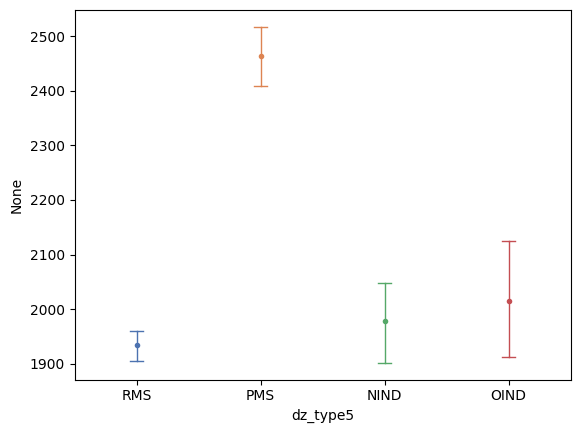

In [33]:
sns.pointplot(x='dz_type5', y=marginal_means, data=data, 
              palette='deep', markers='o', linestyles='-', color='red', 
              capsize=0.1, markersize=2, markeredgewidth=2, linewidth=1)

Does lesion volume and PRL_LEVEL predict choroid volume in MS patients?

In [34]:
volume = "choroid_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ['age', 'Female', 'tiv', 'PMS', 'PRL_LEVEL', 'lesion_vol_cubic', 'intercept']
# predictors = ["age", "Female", "tiv", "lesion_vol_cubic", "PRL_LEVEL", "intercept"]
res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     30.83
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           2.24e-30
Time:                        15:15:31   Log-Likelihood:                -3118.1
No. Observations:                 403   AIC:                             6250.
Df Residuals:                     396   BIC:                             6278.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 15.8154      2.631  

#### Pineal

##### MS vs not-MS

Note: this is significant for MS vs Not-MS, but not when adding disease duration as a covariate

In [35]:
volume = "pineal_volume"

data = df[
    [
        "dz_type2",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "lesion_vol_cubic",
    ]
]
data = data.drop([1548], axis=0)
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type2"].isin(["MS", "!MS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type2"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "tiv", "Male", "MS", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.487
Date:                Mon, 10 Feb 2025   Prob (F-statistic):             0.0427
Time:                        15:15:31   Log-Likelihood:                -2806.2
No. Observations:                 478   AIC:                             5622.
Df Residuals:                     473   BIC:                             5643.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.4347      0.320     -1.357      0.1

##### MS vs NIND vs OIND

Note: this is significant for MS vs Not-MS, but not when adding disease duration as a covariate

In [36]:
volume = "pineal_volume"

data = df[
    [
        "dz_type3",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type3"].isin(["MS", "OIND", "NIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]
# data = data.drop([1548], axis=0)


data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type3"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "MS", "OIND", "PRL", "lesion_vol_cubic", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     3.413
Date:                Mon, 10 Feb 2025   Prob (F-statistic):            0.00144
Time:                        15:15:31   Log-Likelihood:                -2834.6
No. Observations:                 475   AIC:                             5685.
Df Residuals:                     467   BIC:                             5718.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0744      0.386  

1479

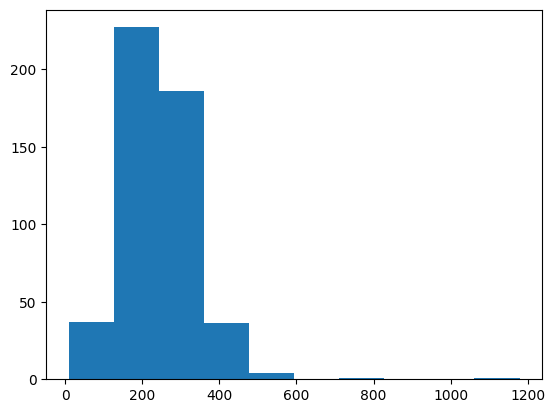

In [45]:
plt.hist(df['pineal_volume'])

median_vol = df['pineal_volume'].median()
tmp_df = df.copy()
tmp_df = tmp_df.sort_values(by="pineal_volume")
tmp_df.index[len(tmp_df) // 2]

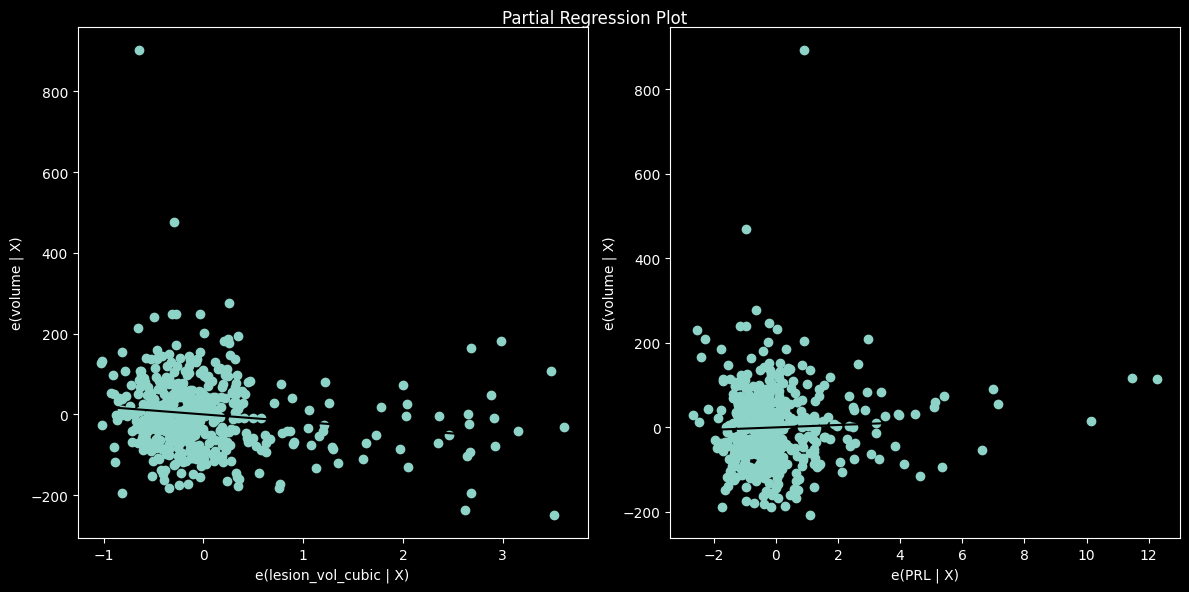

In [350]:
fig = plt.figure(figsize=(12, 6))
sm.graphics.plot_partregress_grid(res, exog_idx=["lesion_vol_cubic", "PRL"], fig=fig)
plt.show()

In [ ]:
fig = sm.graphics.influence_plot(res, criterion="cooks")
fig.tight_layout(pad=1.0)

##### PMS v RMS

In [295]:
volume = "pineal_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "PMS", "lesion_vol_cubic", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.085
Date:                Sun, 09 Feb 2025   Prob (F-statistic):             0.0664
Time:                        23:01:28   Log-Likelihood:                -2359.3
No. Observations:                 405   AIC:                             4731.
Df Residuals:                     399   BIC:                             4755.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.3021      0.367  

In [219]:
volume = "pineal_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS", "NIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]
data = data.drop([1237, 1548], axis=0)
data = data[data['sex'] == "Female"]


data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "tiv", "RMS", "PMS", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.554
Date:                Sun, 09 Feb 2025   Prob (F-statistic):             0.0389
Time:                        22:34:18   Log-Likelihood:                -1999.1
No. Observations:                 343   AIC:                             4008.
Df Residuals:                     338   BIC:                             4027.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.5817      0.373     -1.559      0.1

2


MannwhitneyuResult(statistic=7474.5, pvalue=0.09187797446145998)

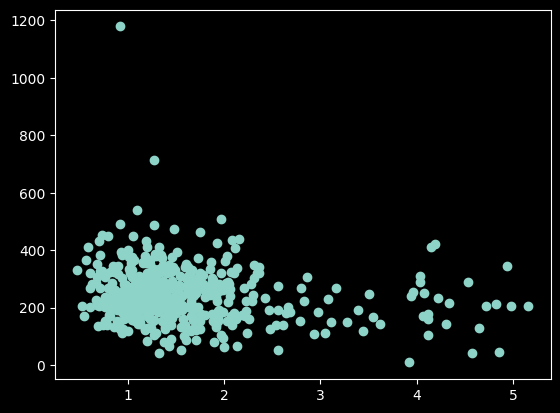

In [326]:
data = df
# data = data.drop([1548], axis=0)
print(data[data['dz_type3'] == "HC"].__len__())

plt.scatter(data['lesion_vol_cubic'], data['pineal_volume'])

# plt.scatter(data.loc[data['dz_type3'] == "MS", 'lesion_vol_cubic'], data.loc[data['dz_type3'] == "MS",'choroid_volume'])

mannwhitneyu(data.loc[data['dz_type3'] == "MS", "pineal_volume"],
         data.loc[data['dz_type3'] == "NIND", "pineal_volume"], 
         nan_policy="omit")

# plt.bar([1,2], [data.loc[data['dz_type3'] == "MS", "pineal_volume"].mean(),
#                 data.loc[data['dz_type3'] == "NIND", "pineal_volume"].mean()],
#                 yerr=[data.loc[data['dz_type3'] == "MS", "pineal_volume"].sem(),
#                       data.loc[data['dz_type3'] == "NIND", "pineal_volume"].sem()],
#                       ecolor="r")

#### Pituitary

##### MS vs not-MS

In [33]:
volume = "pituitary_volume"

data = df[["dz_type2", "age", "sex", "tiv", "flair_contrast", "dzdur", volume]]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type2"].isin(["MS", "!MS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type2"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Male", "tiv", "WITH", "MS", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     7.593
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           7.10e-07
Time:                        15:34:20   Log-Likelihood:                -2995.1
No. Observations:                 479   AIC:                             6002.
Df Residuals:                     473   BIC:                             6027.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -1.4413      0.470     -3.064      0.0

##### MS vs NIND vs OIND

In [290]:
volume = "pituitary_volume"

data = df[["dz_type3", "age", "sex", "tiv", "flair_contrast", "dzdur", "lesion_vol_cubic", volume]]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type3"].isin(["MS", "OIND", "NIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type3"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "MS", "OIND", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     7.715
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           5.47e-07
Time:                        22:59:30   Log-Likelihood:                -2983.1
No. Observations:                 477   AIC:                             5978.
Df Residuals:                     471   BIC:                             6003.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -1.4511      0.473     -3.068      0.0

##### PMS v RMS

In [138]:
volume = "pituitary_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS", "OIND", "NIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["tiv", "PMS", "RMS", "OIND", "intercept"]
predictors = [
    "age",
    "Female",
    "tiv",
    "RMS",
    "PMS",
    "OIND",
    "PRL_LEVEL",
    "lesion_vol_cubic",
    "intercept",
]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.936
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           7.09e-06
Time:                        18:24:32   Log-Likelihood:                -2970.8
No. Observations:                 475   AIC:                             5960.
Df Residuals:                     466   BIC:                             5997.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -1.2095      0.548  

### Ordinal Regression on EDSS

Predict EDSS score using volumes. Use MS vs OIND vs NIND as covariate (in addition to the others)

In [195]:
data = df[
    [
        "dz_type3",
        "dz_type",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "extracted_EDSS",
        "ARMSS",
        "PRL_LEVEL",
        "PRL",
        "lesion_vol_cubic",
        "MSSS",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "thalamus",
        "brain",
        "cortical_thickness",
        "dzdur",
    ]
]
data = data[data["dz_type3"].isin(["MS"])]
data.loc[:, ["dz_type3_factor"]], _ = data["dz_type3"].factorize(sort=False)

data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]
# df['extracted_EDSS'] = df['extracted_EDSS'] * 2
data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None
# data['extracted_EDSS'] = pd.Categorical(data['extracted_EDSS'], ordered=True)

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

# predictors = ['age', 'Female', 'tiv', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']
# predictors = ['age', 'Female', 'tiv', 'RMS', 'PRL_LEVEL', 'lesion_vol_cubic', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']

predictors = [
    "age",
    "Female",
    "tiv",
    "PRL_LEVEL",
    "lesion_vol_cubic",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "dzdur",
    "intercept",
]

data = data.dropna()

# mod = OrderedModel(data2['numEDSS'],
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(
    data["extracted_EDSS"].astype("float"), data[predictors].astype("float")
).fit(missing="drop")

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         extracted_EDSS   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     13.55
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           9.62e-19
Time:                        20:14:20   Log-Likelihood:                -721.19
No. Observations:                 370   AIC:                             1462.
Df Residuals:                     360   BIC:                             1502.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0388      0.010  

Choroid volume is weakly associated with worse EDSS when correcting for age, sex, tiv but not for dzdur

In [198]:
predictors = [
    "tiv",
    "age",
    "Female",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "intercept",
]

data = data.dropna()

# mod = OrderedModel(data2['numEDSS'],
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(
    data["extracted_EDSS"].astype("float"), data[predictors].astype("float")
).fit(missing="drop")

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         extracted_EDSS   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     14.43
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           8.98e-15
Time:                        20:14:37   Log-Likelihood:                -735.58
No. Observations:                 370   AIC:                             1485.
Df Residuals:                     363   BIC:                             1513.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
tiv              -7.683e-07   8.63e-07  

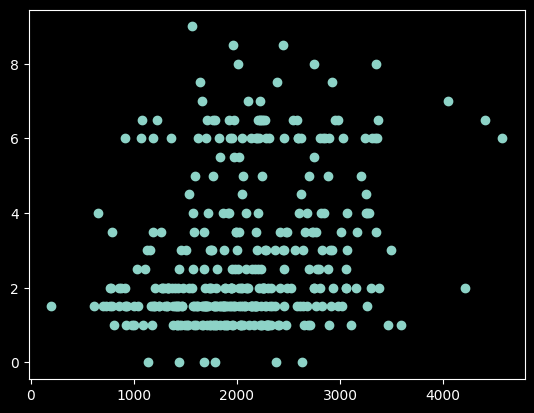

In [120]:
plt.scatter(data['choroid_volume'], data['extracted_EDSS'])

In [124]:
data = df[
    [
        "dz_type3",
        "dz_type",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "extracted_EDSS",
        "ARMSS",
        "PRL_LEVEL",
        "lesion_vol_cubic",
        "MSSS",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "thalamus",
        "brain",
        "cortical_thickness",
    ]
]
data = data[data["dz_type3"].isin(["MS"])]
data.loc[:, ["dz_type3_factor"]], _ = data["dz_type3"].factorize(sort=False)

data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]
# df['extracted_EDSS'] = df['extracted_EDSS'] * 2
data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None
# data['extracted_EDSS'] = pd.Categorical(data['extracted_EDSS'], ordered=True)

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

# predictors = ['age', 'Female', 'tiv', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']
predictors = [
    "age",
    "Female",
    "tiv",
    "PRL_LEVEL",
    "lesion_vol_cubic",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "intercept",
]

data = data.dropna()

# mod = OrderedModel(data2['numEDSS'],
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(data["MSSS"].astype("float"), data[predictors].astype("float")).fit(
    missing="drop"
)

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSSS   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.615
Date:                Sun, 09 Feb 2025   Prob (F-statistic):              0.142
Time:                        17:23:26   Log-Likelihood:                -852.53
No. Observations:                 370   AIC:                             1719.
Df Residuals:                     363   BIC:                             1746.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0103      0.011  

### JASP Data

In [151]:
columns = [
    "dz_type",
    "dz_type2",
    "dz_type3",
    "dz_type4",
    "dz_type5",
    "age",
    "sex",
    "tiv",
    "flair_contrast",
    "extracted_EDSS",
    "ARMSS",
    "PRL_LEVEL",
    "PRL",
    "lesion_vol_cubic",
    "MSSS",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "thalamus",
    "brain",
    "cortical_thickness",
    "dzdur",
]
df_jasp = df[columns]
df_jasp = pd.concat((df_jasp, pd.get_dummies(df_jasp["sex"])), axis=1)
df_jasp = df_jasp.loc[df_jasp["dzdur"] != ".", :]

for i, row in df_jasp.iterrows():
    if row["Female"]:
        df_jasp.loc[i, "Female"] = 1
    else:
        df_jasp.loc[i, "Female"] = 0

    if row["Male"]:
        df_jasp.loc[i, "Male"] = 1
    else:
        df_jasp.loc[i, "Male"] = 0

/tmp/ipykernel_5002/646010725.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, "Female"] = 1
/tmp/ipykernel_5002/646010725.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, "Male"] = 0


In [152]:
jasp_dir = Path(
    "/home/srs-9/Projects/ms_mri/monai_analysis/choroid_pineal_pituitary_T1-1/jasp_data"
)

df_jasp.to_csv(jasp_dir / "dataframe.csv")

In [153]:
df["dz_type3"].unique()

array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

In [154]:
df_jasp3 = df_jasp[df_jasp["dz_type3"].isin(["MS", "NIND", "OIND"])]
df_jasp5 = df_jasp[df_jasp["dz_type5"].isin(["RMS", "PMS", "NIND", "OIND"])]
df_jasp_ms = df_jasp[df_jasp["dz_type5"].isin(["RMS", "PMS"])]

df_jasp3.to_csv(jasp_dir / "dataframe3.csv")
df_jasp5.to_csv(jasp_dir / "dataframe5.csv")
df_jasp_ms.to_csv(jasp_dir / "dataframeMS.csv")